
<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/mlab/w3d2_part2_dqn_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only execute on Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone --depth 1 https://github.com/EffiSciencesResearch/ML4G.git
    !cd ML4G
    !pip install -r /content/ML4G/requirements.txt --quiet
    %cd /content/ML4G/mlab

Cloning into 'ML4G'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 372 (delta 54), reused 260 (delta 36), pack-reused 0
Receiving objects: 100% (372/372), 386.13 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (387/387), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.2 MB/s eta 0:00:00
  Preparing met

# W3D2 - Part 2 - DQN Algorithm

In this section, you'll implement Deep Q-Learning, often referred to as DQN for "Deep Q-Network". This was used in a landmark paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

At the time, I was very excited about this paper - the idea that convolutional neural networks could look at Atari game pixels and "see" gameplay-relevant features like a Space Invader was new and noteworthy. In 2022, we take for granted that convnets work, so we're going to focus on the RL aspect and not the vision aspect today.

## Fast Feedback Loops

We want to have faster feedback loops, and learning from Atari pixels doesn't achieve that. It might take 15 minutes per training run to get an agent to do well on Breakout, and that's if your implementation is relatively optimized. Even waiting 5 minutes to learn Pong from pixels will limit your ability to iterate relative to environments that are as simple as possible.

## CartPole

The classic environment "CartPole-v0" is simple to understand, yet hard enough for a RL agent to be interesting. [Here's a video of a RL agent playing CartPole](https://www.youtube.com/watch?v=46wjA6dqxOM); by the end of the day your agent will be able to do this and more!

You can see the source for CartPole [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py); don't worry about the implementation but do read the documentation to understand the format of the actions and observations.

The simple physics involved would be very easy for a model-based algorithm to fit, but today we're doing it model-free: your agent has no idea that these observations represent positions or velocities, and it has no idea what the laws of physics are.

Each environment can have different versions registered to it. By consulting [the Gym source](https://github.com/openai/gym/blob/master/gym/envs/__init__.py) you can see that CartPole-v0 and CartPole-v1 are the same environment, except that v1 has longer episodes. Again, a minor change like this can affect what algorithms score well; an agent might consistently survive for 200 steps but not be stable out to 500 steps.

## Beyond CartPole

If things go well and your agent masters CartPole, the next harder challenges are [Acrobot-v1](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py), and [MountainCar-v0](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py). These also have discrete action spaces, which are the only type we're dealing with today. Feel free to Google for appropriate hyperparameters for these other problems - in a real RL problem you would have to run a hyperparameter search using the techniques we learned on a previous day because bad hyperparameters in RL often completely fail to learn, even if the algorithm is perfectly correct.

There are many more exciting environments to play in, but generally they're going to require more compute and more optimization than we have time for today. If you finish the main material, some ones I like are:

- [Minimalistic Gridworld Environments](https://github.com/Farama-Foundation/gym-minigrid) - a fast gridworld environment for experiments with sparse rewards and natural language instruction.
- [microRTS](https://github.com/santiontanon/microrts) - a small real-time strategy game suitable for experimentation.
- [Megastep](https://andyljones.com/megastep/) - RL environment that runs fully on the GPU (fast!)

## Outline of the Exercises

- Implement the Q-network that maps a state to an estimated value for each action.
- Implement the policy which chooses actions based on the Q-network, plus epsilon greedy randomness just like in the bandit case.
- Implement a replay buffer to the collected (state, action, reward, next_state) tuples, which are called experiences for short.
- Piece everything together into a training loop and train your agent.

## Interesting Resources (not required reading)

- [An Outsider's Tour of Reinforcement Learning](http://www.argmin.net/2018/06/25/outsider-rl/) - comparison of RL techniques with the engineering discipline of control theory.
- [Towards Characterizing Divergence in Deep Q-Learning](https://arxiv.org/pdf/1903.08894.pdf) - analysis of what causes learning to diverge.
- [Divergence in Deep Q-Learning: Tips and Tricks](https://amanhussain.com/post/divergence-deep-q-learning/) - includes some plots of average returns for comparison.
- [Deep RL Bootcamp](https://sites.google.com/view/deep-rl-bootcamp/lectures) - 2017 bootcamp with video and slides. Good if you like videos.
- [DQN debugging using OpenAI gym Cartpole](https://adgefficiency.com/dqn-debugging/) - random dude's adventures in trying to get it to work.
- [CleanRL DQN](https://github.com/vwxyzjn/cleanrl) - single file implementations of RL algorithms. Your starter code today is based on this; try not to spoiler yourself by looking at the solutions too early!
- [Deep Reinforcement Learning Doesn't Work Yet](https://www.alexirpan.com/2018/02/14/rl-hard.html) - 2018 article describing difficulties preventing industrial adoption of RL.
- [Deep Reinforcement Learning Works - Now What?](https://tesslerc.github.io/posts/drl_works_now_what/) - 2020 response to the previous article highlighting recent progress.
- [Seed RL](https://github.com/google-research/seed_rl) - example of distributed RL using Docker and GCP.


In [2]:
import argparse
import os
import random
import sys
import time
import dataclasses
from dataclasses import dataclass
from distutils.util import strtobool
from typing import Any, Iterable, List, Optional, Tuple, Union
import gym
import gym.envs.registration
import numpy as np
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
from gym.spaces import Box, Discrete
from matplotlib import pyplot as plt
from numpy.random import Generator
from torch.utils.tensorboard import SummaryWriter
import w3d2_test
from w3d2_utils import make_env

MAIN = __name__ == "__main__"
IS_CI = os.getenv("IS_CI")
os.environ["SDL_VIDEODRIVER"] = "dummy"

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(



## The Q-network

The Q-network takes in an observation and outputs a number for each available action that predicts how good it is. For best results, the architecture of the Q-network can be customized to each particular problem. For example, [the architecture of OpenAI Five](https://cdn.openai.com/research-covers/openai-five/network-architecture.pdf) used to play DOTA 2 is quite complex and involves LSTMs.

For learning from pixels, a simple convolutional network and some fully connected layers does quite well. Where we have already processed features here, it's even easier - an MLP of this size should be plenty large for any environment today. Your code should support running the network on either the GPU or CPU, but for CartPole it was actually faster to use the CPU on my hardware.

Implement the Q-network using alternating Linear and ReLU layers. Should there be a ReLU at the very end? Why or why not?

<details>

<summary>Solution - ReLU at the end</summary>

If you end with a ReLU, then your network can only predict 0 or positive rewards. This will cause problems as soon as you encounter an environment with negative rewards or you try to do some scaling of the rewards.

</details>


In [3]:
class QNetwork(nn.Module):
    def __init__(self, num_observations: int, num_actions: int, hidden_sizes: List[int] = [120, 84]):
        super().__init__()
        layers = nn.Sequential(
          nn.Linear(num_observations, hidden_sizes[0]),
          nn.ReLU()
        )
        for i in range(len(hidden_sizes)-1):
          layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
          layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], num_actions))
        layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.network(x)


if MAIN:
    net = QNetwork(num_observations=4, num_actions=2)
    n_params = sum((p.nelement() for p in net.parameters()))
    print(net)
    print(f"Total number of parameters: {n_params}")
    assert n_params == 10934

QNetwork(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=2, bias=True)
    (5): ReLU()
  )
)
Total number of parameters: 10934


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



## Replay Buffer

In the supervised learning setting, training examples should be drawn i.i.d. from some distribution, and we hope to generalize to future examples from that distribution.

In RL, the distribution of experiences is a moving target that changes every time the policy changes. This is why the training loss curve isn't going to have a nice steady decrease like in supervised learning.

Another problem is that states within an episode are correlated and not i.i.d. at all. For example, in a chess game if you happen to be far ahead in pieces, for the rest of the game most actions will have a much higher than average expected reward. Even bad moves will have a high reward if they aren't bad enough to cause you to actually lose. If a batch of these actions was presented to the network, it would not have a representative sample of what chess is like.

### Replay buffer with uniform sampling

A simple strategy that works decently well to combat these problems is to store the agent's "experiences" in a buffer, which is then sampled from to train the policy further. This works as follows:

1. We start with a policy which we run in the environment for some number of steps.
2. At each step we take the (`observation`, `action`, `reward`, `done`, `next_observation`) information that we got from that step and add it to the buffer.
3. After we've done this for enough steps, we can randomly sample a batch of experience tuples from the buffer to train the policy further.

Intuitively, if we want the policy to play well in all sorts of states, the sampled batch should be a representative sample of all the diverse scenarios that can happen in the environment.

For complex environments, this implies a very large batch size (or doing something better than uniform sampling). [OpenAI Five](https://cdn.openai.com/dota-2.pdf), used batch sizes of over 2 million experiences for Dota 2.

The capacity of the replay buffer is yet another hyperparameter; if it's too small then it's just going to be full of recent and correlated examples. But if it's too large, we pay an increasing cost in memory usage and the information may be too old to be relevant.

Implement `ReplayBuffer`. It only needs to handle a discrete action space, and you can assume observations are some shape of dtype `np.float32`.

### Vectorized Environments

Our agent won't interact directly with an instance of the CartPole `Env`, but with a wrapper class `gym.vector.SyncVectorEnv` which behaves like an array of `Env` instances. This doesn't actually make things any faster because it's just a regular `for` loop inside, but it means you can conveniently call `step` with an array of actions (one for each instance) and get back arrays of observations, rewards, etc.

We're introducing this today because PPO will use it tomorrow with multiple instances inside, but DQN will only use it with a single instance.

In general, don't worry about execution speed today. It's okay to use for loops and accept that not everything can be efficiently vectorized. If we actually wanted to go fast, we would likely ditch Python entirely and write everything in C++.


In [4]:
@dataclass
class ReplayBufferSamples:
    """
    Samples from the replay buffer, converted to PyTorch for use in neural network training.

    obs: shape (sample_size, *observation_shape), dtype t.float
    actions: shape (sample_size, ) dtype t.int
    rewards: shape (sample_size, ), dtype t.float
    dones: shape (sample_size, ), dtype t.bool
    next_observations: shape (sample_size, *observation_shape), dtype t.float
    """

    observations: t.Tensor
    actions: t.Tensor
    rewards: t.Tensor
    dones: t.Tensor
    next_observations: t.Tensor


class ReplayBuffer:
    rng: Generator

    def __init__(
        self,
        buffer_size: int,
        num_actions: int,
        observation_shape: tuple,
        num_environments: int,
        seed: int,
    ):
        assert (
            num_environments == 1
        ), "This buffer only supports SyncVectorEnv with 1 environment inside."
        "SOLUTION"
        self.buffer_size = buffer_size
        self.num_actions = num_actions
        self.observation_shape = observation_shape
        self.num_environments = num_environments
        self.observations = np.zeros(
            (self.buffer_size,) + self.observation_shape, dtype=np.float32
        )
        self.next_observations = np.zeros(
            (self.buffer_size,) + self.observation_shape, dtype=np.float32
        )
        self.actions = np.zeros(self.buffer_size, dtype=np.int64)
        self.rewards = np.zeros(self.buffer_size, dtype=np.float32)
        self.dones = np.zeros(self.buffer_size, dtype=np.float32)
        self.pos = 0
        self.full = False
        self.rng = np.random.default_rng(seed)

    def add(
        self,
        obs: np.ndarray,
        actions: np.ndarray,
        rewards: np.ndarray,
        dones: np.ndarray,
        next_obs: np.ndarray,
    ) -> None:
        """
        obs: shape (num_environments, *observation_shape) Observation before the action
        actions: shape (num_environments, ) the action chosen by the agent
        rewards: shape (num_environments, ) the reward after the after
        dones: shape (num_environments, ) if True, the episode ended and was reset automatically
        next_obs: shape (num_environments, *observation_shape) Observation after the action. If done is True, this should be the terminal observation, NOT the first observation of the next episode.
        """
        "SOLUTION"
        if self.pos == 0:  # It's slow to do this on every add, just check once
            assert obs.shape == (self.num_environments,) + self.observation_shape
            assert actions.shape == (self.num_environments,)
            assert rewards.shape == (self.num_environments,)
            assert dones.shape == (self.num_environments,)
            assert next_obs.shape == (self.num_environments,) + self.observation_shape
        self.observations[self.pos] = obs
        self.actions[self.pos] = actions
        self.rewards[self.pos] = rewards
        self.dones[self.pos] = dones
        self.next_observations[self.pos] = next_obs
        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True
            self.pos = 0

    def sample(self, sample_size: int, device: t.device) -> ReplayBufferSamples:
        """Uniformly sample sample_size entries from the buffer and convert them to PyTorch tensors on device.

        Sampling is with replacement, and sample_size may be larger than the buffer size.
        """
        "SOLUTION"
        hi = self.buffer_size if self.full else self.pos
        ind = self.rng.integers(0, hi, size=sample_size)

        return ReplayBufferSamples(
            t.as_tensor(self.observations[ind], device=device),
            t.as_tensor(self.actions[ind], device=device),
            t.as_tensor(self.rewards[ind], device=device),
            t.as_tensor(self.dones[ind], device=device),
            t.as_tensor(self.next_observations[ind], device=device),
        )
        # TBD: how helpful is it to call env.normalize_obs and env.normalize_reward here?




if MAIN:
    w3d2_test.test_replay_buffer_single(ReplayBuffer)
    w3d2_test.test_replay_buffer_deterministic(ReplayBuffer)
    w3d2_test.test_replay_buffer_wraparound(ReplayBuffer)

w3d2_test.test_replay_buffer_single passed in 0.12s.
w3d2_test.test_replay_buffer_deterministic passed in 0.08s.
w3d2_test.test_replay_buffer_wraparound passed in 0.03s.



## Environment Resets

There's a subtlety to the Gym API around what happens when the agent fails and the episode is terminated. Our environment is set up to automatically reset at the end of an episode, but when this happens the `next_obs` returned from `step` is actually the initial observation of the new episode.

What we want to store in the replay buffer is the final observation of the old episode. The code to do this is shown below.

- Run the code and inspect the replay buffer contents. Referring back to the [CartPole source](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py), do the numbers make sense?
- Look at the sample, and see if it looks properly shuffled.


In [5]:
if MAIN:
    rb = ReplayBuffer(buffer_size=256, num_actions=2, observation_shape=(4,), num_environments=1, seed=0)
    envs = gym.vector.SyncVectorEnv([make_env("CartPole-v0", 0, 0, False, "test")])
    obs = envs.reset()
    for i in range(512):
        actions = np.array([0])
        (next_obs, rewards, dones, infos) = envs.step(actions)
        real_next_obs = next_obs.copy()
        for (i, done) in enumerate(dones):
            if done:
                real_next_obs[i] = infos[i]["terminal_observation"]
        rb.add(obs, actions, rewards, dones, real_next_obs)
        obs = next_obs
    sample = rb.sample(128, t.device("cpu"))


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(



## Epsilon Greedy Policy

In later methods like policy gradient, we'll explicitly represent the policy as its own neural network. In DQN, the policy is implicitly defined by the Q-network: we take the action with the maximum predicted reward. This means we'll tend to choose actions which the Q-network is overly optimistic about, and then our agent will get less reward than expected.


In [7]:
def epsilon_greedy_policy(
    envs: gym.vector.SyncVectorEnv, q_network: QNetwork, rng: Generator, obs: t.Tensor, epsilon: float
) -> np.ndarray:
    """With probability epsilon, take a random action. Otherwise, take a greedy action according to the q_network.

    cartpole: obs shape (envs, obs space), action: (shape, )
    probs: obs shape (envs,)

    Return: (n_environments, ) the sampled action for each environment.
    """
    prob = rng.random()
    if prob < epsilon:
      actions = envs.action_space.sample()
    else:
      actions = q_network(obs).argmax(dim=-1).cpu().numpy()
    assert actions.shape == (envs.num_envs,)
    return actions


if MAIN:
    w3d2_test.test_epsilon_greedy_policy(epsilon_greedy_policy)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


w3d2_test.test_epsilon_greedy_policy passed in 1.31s.



## Exploration

DQN makes no attempt to explore intelligently. The exploration strategy is the same as the basic approach from Chapter 2 of Sutton and Barto: agents take a random action with probability `epsilon`, and `epsilon` is gradually decreased. The Q-network is also randomly initialized, so its predictions of what is the best action to take are also pretty random to start.

Some games like Montezuma's Revenge have sparse rewards that require more advanced exploration methods to obtain. The player is required to collect specific keys to unlock specific doors, but unlike humans, DQN has no prior knowledge about what a key or a door is, and it turns out that bumbling around randomly has too low of a probability of correctly matching a key to its door. Even if the agent does manage to do this, the long separation between finding the key and going to the door makes it hard to learn that picking the key up was important.

As a result, DQN scored an embarrassing 0% of average human performance on this game.

### Reward Shaping

One solution to sparse rewards is to use human knowledge to define auxillary reward functions that are more dense and make the problem easier. In this specific example, we could give it a reward for picking up a key. What could possibly go wrong?

### Reward Hacking

One time this was tried, the reward was given slightly too early and the agent learned it could go close to the key without quite picking it up, obtain the auxillary reward, and then back up and repeat. See [here](https://www.youtube.com/watch?v=_sFp1ffKIc8&list=PLehfUY5AEKX-g-QNM7FsxRHgiTOCl-1hv&index=4) for a video of this happening.

More examples of unintended agent behavior are [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vRPiprOaC3HsCf5Tuum8bRfzYUiKLRqJmbOoC-32JorNdfyTiRRsR7Ea5eWtvsWzuxo8bjOxCG84dAg/pubhtml).

### Advanced Exploration

It would be better if the agent didn't require these auxillary rewards, and could rely on other signals in the environment that a state might be worth exploring. One idea is that a state which is "surprising" or "unpredictable" in some sense might be valuable. In 2018, OpenAI released [Random Network Distillation](https://openai.com/blog/reinforcement-learning-with-prediction-based-rewards/) which made progress in operationalizing this notion. In 2019, an excellent paper [First return, then explore](https://arxiv.org/pdf/2004.12919v6.pdf) found an even better approach.

For now, implement the basic linearly decreasing exploration schedule. Plot it and check that it looks right.

<details>

<summary>Solution - Plot of the Intended Schedule</summary>

<p align="center">
    <img src="https://github.com/EffiSciencesResearch/ML4G/blob/main/mlab/w3d2_epsilon_schedule.png?raw=1"/>
</p>

</details>


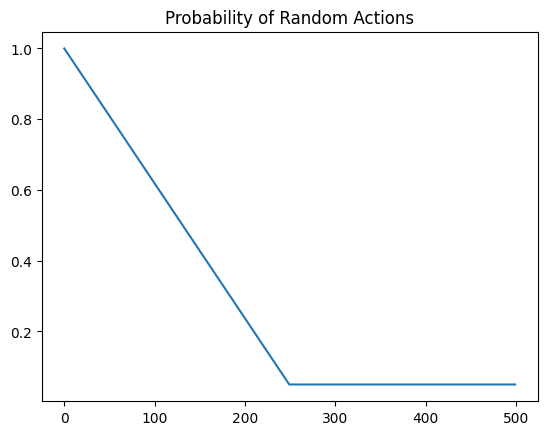

In [11]:
def linear_schedule(
    current_step: int, start_e: float, end_e: float, exploration_fraction: float, total_timesteps: int
) -> float:
    """Return the appropriate epsilon for the current step.

    Epsilon should be start_e at step 0 and decrease to end_e at step (exploration_fraction * total_timesteps).
    """
    if current_step == 0:
      return start_e
    if current_step >= (exploration_fraction * total_timesteps):
      return end_e

    slope = (end_e - start_e) / (exploration_fraction * total_timesteps - 1)  
    return start_e + (slope) * current_step


if MAIN:
    epsilons = [
        linear_schedule(step, start_e=1.0, end_e=0.05, exploration_fraction=0.5, total_timesteps=500)
        for step in range(500)
    ]
    plt.plot(epsilons)
    plt.title("Probability of Random Actions")


## Probe Environments

Extremely simple probe environments are a great way to debug your algorithm. Implement the second probe environment below by looking at the first probe.


In [12]:
ObsType = np.ndarray
ActType = int


class Probe1(gym.Env):
    """One action, observation of [0.0], one timestep long, +1 reward.

    We expect the agent to rapidly learn that the value of the constant [0.0] observation is +1.0. Note we're using a continuous observation space for consistency with CartPole.
    """

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        "SOLUTION"
        super().__init__()
        self.observation_space = Box(np.array([0]), np.array([0]))
        self.action_space = Discrete(1)
        self.reset()

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, dict]:
        "SOLUTION"
        return np.array([0]), 1.0, True, {}

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        "SOLUTION"
        if return_info:
            return np.array([0.0]), {}
        return np.array([0.0])


gym.envs.registration.register(id="Probe1-v0", entry_point=Probe1)
if MAIN:
    env = gym.make("Probe1-v0")
    assert env.observation_space.shape == (1,)
    assert env.action_space.shape == ()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe1-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")



### Additional Probe Environments

Feel free to skip ahead for now, and implement these as needed to debug your model.


In [13]:
class Probe2(gym.Env):
    """One action, observation of [-1.0] or [+1.0], one timestep long, reward equals observation.

    We expect the agent to rapidly learn the value of each observation is equal to the observation.
    """

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        "SOLUTION"
        super().__init__()
        self.observation_space = Box(np.array([-1.0]), np.array([+1.0]))
        self.action_space = Discrete(1)
        self.reset()
        self.reward = None

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, dict]:
        "SOLUTION"
        assert self.reward is not None
        return np.array([0]), self.reward, True, {}

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        "SOLUTION"
        super().reset(seed=seed)
        self.reward = 1.0 if self.np_random.random() < 0.5 else -1.0
        if return_info:
            return np.array([self.reward]), {}
        return np.array([self.reward])


gym.envs.registration.register(id="Probe2-v0", entry_point=Probe2)



class Probe3(gym.Env):
    """One action, [0.0] then [1.0] observation, two timesteps, +1 reward at the end.

    We expect the agent to rapidly learn the discounted value of the initial observation.
    """

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        "SOLUTION"
        super().__init__()
        self.observation_space = Box(np.array([-0.0]), np.array([+1.0]))
        self.action_space = Discrete(1)
        self.reset()

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, dict]:
        "SOLUTION"
        self.n += 1
        if self.n == 1:
            return np.array([1.0]), 0.0, False, {}
        elif self.n == 2:
            return np.array([0.0]), 1.0, True, {}
        raise ValueError(self.n)

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        "SOLUTION"
        super().reset(seed=seed)
        self.n = 0
        if return_info:
            return np.array([0.0]), {}
        return np.array([0.0])


gym.envs.registration.register(id="Probe3-v0", entry_point=Probe3)


class Probe4(gym.Env):
    """Two actions, [0.0] observation, one timestep, reward is -1.0 or +1.0 dependent on the action.

    We expect the agent to learn to choose the +1.0 action.
    """

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        "SOLUTION"
        super().__init__()
        self.observation_space = Box(np.array([-0.0]), np.array([+0.0]))
        self.action_space = Discrete(2)
        self.reset()

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, dict]:
        "SOLUTION"
        reward = 1.0 if action == 1 else -1.0
        return np.array([0.0]), reward, True, {}

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        "SOLUTION"
        super().reset(seed=seed)
        if return_info:
            return np.array([0.0]), {}
        return np.array([0.0])


gym.envs.registration.register(id="Probe4-v0", entry_point=Probe4)


class Probe5(gym.Env):
    """Two actions, random 0/1 observation, one timestep, reward is 1 if action equals observation otherwise -1.

    We expect the agent to learn to match its action to the observation.
    """

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        "SOLUTION"
        super().__init__()
        self.observation_space = Box(np.array([-1.0]), np.array([+1.0]))
        self.action_space = Discrete(2)
        self.reset()

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, dict]:
        "SOLUTION"
        reward = 1.0 if action == self.obs else -1.0
        return np.array([-1.0]), reward, True, {}

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        "SOLUTION"
        super().reset(seed=seed)
        self.obs = 0 if self.np_random.random() < 0.5 else 1
        if return_info:
            return np.array([self.obs], dtype=float), {}
        return np.array([self.obs], dtype=float)


gym.envs.registration.register(id="Probe5-v0", entry_point=Probe5)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe2-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe3-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe4-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe5-v0
  logger.warn(f"Overriding environment {id}")



## Main DQN Algorithm

All the boilerplate code is provided for you. You just need to fill in the three placeholders as indicated, referring to Algorithm 1 in the [DQN paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) (or the [DQN step-by-step blog post](https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b)). Note that since you aren't preprocessing pixels, your version will just directly store states.

A sample invocation that will let you see your agent's progress in Weights and Biases, including videos of it playing episodes would look like:

`python your_script.py --track --capture-video`

I recommend that you start by running statements line by line in the REPL and verifying that things are as you expect, then pasting them into the function when they work.

Don't be discouraged if it's not working - it's normal for debugging RL to take longer than you would expect. Add asserts or your own tests, implement an appropriate probe environment, try anything in the Andy Jones post that sounds promising, and try to notice confusion.

One more tip: when gathering experiences, make sure you have a line `obs = next_obs` at an appropriate location, or you'll just keep passing in the same observation on every iteration. I've already forgotten this line twice.

### Logging Metrics

You can view your metrics either in the IDE using Tensorboard (VS Code has built-in Tensorboard support) or remotely on Weights and Biases. Some of the logs won't work properly until you define a variable with the expected name.

### Expected Behavior of the Loss

In supervised learning, we want our loss to be decreasing and it's a bad sign if it's actually increasing. In RL, it's the reward that should be (noisily) increasing over time.

Our agent's loss function just reflects how close together the Q-network's estimates are to the experiences currently sampled from the replay buffer.

This means that once the agent starts to learn something and do better at the problem, it's expected for the loss to increase.

For example, the Q-network initially learned some state was bad, because an agent that reached them was just derping around randomly and died shortly after. But now it's getting evidence that the same state is good, now that the agent that reached the state has a better idea what to do next. A higher loss is thus actually a good sign that learning is actively occurring if it's correlated with an increase in average reward obtained.


In [15]:
@dataclass
class DQNArgs:
    exp_name: str = os.path.basename(globals().get("__file__", "DQN_implementation").rstrip(".py"))
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True
    track: bool = False
    wandb_project_name: str = "w3d2"
    wandb_entity: Optional[str] = None
    capture_video: bool = False
    env_id: str = "CartPole-v0"
    total_timesteps: int = 500000
    learning_rate: float = 0.00025
    buffer_size: int = 10000
    gamma: float = 0.99
    target_network_frequency: int = 500
    batch_size: int = 128
    start_e: float = 1.0
    end_e: float = 0.05
    exploration_fraction: float = 0.5
    learning_starts: int = 10000
    train_frequency: int = 10
    use_target_network: bool = False


arg_help_strings = {
    "exp_name": "the name of this experiment",
    "seed": "seed of the experiment",
    "torch_deterministic": "if toggled, `torch.backends.cudnn.deterministic=False`",
    "cuda": "if toggled, cuda will be enabled by default",
    "track": "if toggled, this experiment will be tracked with Weights and Biases",
    "wandb_project_name": "the wandb's project name",
    "wandb_entity": "the entity (team) of wandb's project",
    "capture_video": "whether to capture videos of the agent performances (check out `videos` folder)",
    "env_id": "the id of the environment",
    "total_timesteps": "total timesteps of the experiments",
    "learning_rate": "the learning rate of the optimizer",
    "buffer_size": "the replay memory buffer size",
    "gamma": "the discount factor gamma",
    "target_network_frequency": "the timesteps it takes to update the target network",
    "batch_size": "the batch size of samples from the replay memory",
    "start_e": "the starting epsilon for exploration",
    "end_e": "the ending epsilon for exploration",
    "exploration_fraction": "the fraction of `total-timesteps` it takes from start-e to go end-e",
    "learning_starts": "timestep to start learning",
    "train_frequency": "the frequency of training",
    "use_target_network": "If True, use a target network.",
}
toggles = ["torch_deterministic", "cuda", "track", "capture_video"]


def parse_args(arg_help_strings=arg_help_strings, toggles=toggles) -> DQNArgs:
    parser = argparse.ArgumentParser()
    for field in dataclasses.fields(DQNArgs):
        flag = "--" + field.name.replace("_", "-")
        type_function = field.type if field.type != bool else lambda x: bool(strtobool(x))
        toggle_kwargs = {"nargs": "?", "const": True} if field.name in toggles else {}
        parser.add_argument(
            flag, type=type_function, default=field.default, help=arg_help_strings[field.name], **toggle_kwargs
        )
    return DQNArgs(**vars(parser.parse_args()))


def setup(args: DQNArgs) -> Tuple[str, SummaryWriter, np.random.Generator, t.device, gym.vector.SyncVectorEnv]:
    """Helper function to set up useful variables for the DQN implementation"""
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % "\n".join([f"|{key}|{value}|" for (key, value) in vars(args).items()]),
    )
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    rng = np.random.default_rng(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
    assert isinstance(envs.single_action_space, Discrete), "only discrete action space is supported"
    return (run_name, writer, rng, device, envs)


def log(
    writer: SummaryWriter,
    start_time: float,
    step: int,
    predicted_q_vals: t.Tensor,
    loss: Union[float, t.Tensor],
    infos: Iterable[dict],
    epsilon: float,
):
    """Helper function to write relevant info to TensorBoard logs, and print some things to stdout"""
    if step % 100 == 0:
        writer.add_scalar("losses/td_loss", loss, step)
        writer.add_scalar("losses/q_values", predicted_q_vals.mean().item(), step)
        writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)), step)
        if step % 10000 == 0:
            print("SPS:", int(step / (time.time() - start_time)))
    for info in infos:
        if "episode" in info.keys():
            print(f"global_step={step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], step)
            writer.add_scalar("charts/epsilon", epsilon, step)
            break

In [16]:
def train_dqn(args: DQNArgs):
    (run_name, writer, rng, device, envs) = setup(args)
    "YOUR CODE: Create your Q-network, Adam optimizer, and replay buffer here."
    obs_shape = envs.single_observation_space.shape
    num_observations = np.array(obs_shape, dtype=int).prod()
    num_actions = envs.single_action_space.n
    q_network = QNetwork(num_observations, num_actions).to(device)
    optimizer = torch.optim.Adam(q_network.parameters(), lr=args.learning_rate)

    if args.use_target_network:
      target_network = QNetwork(num_observations, num_actions).to(device)
      target_network.load_state_dict(q_network.state_dict())

    rb = ReplayBuffer(
      args.buffer_size,
      num_actions,
      envs.single_observation_space.shape,
      len(envs.envs),
      args.seed,
    )

    start_time = time.time()
    obs = envs.reset()
    for step in range(args.total_timesteps):
        "YOUR CODE: Sample actions, step the environment, and record the results in the replay buffer here."

        epsilon = linear_schedule(step, args.start_e, args.end_e, args.exploration_fraction, args.total_timesteps)
        actions = epsilon_greedy_policy(
          envs, q_network, rng, torch.Tensor(obs).to(device), epsilon
        )
        assert actions.shape == (len(envs.envs),)

        next_obs, rewards, dones, infos = envs.step(actions)
        real_next_obs = next_obs.copy()

        for idx, d in enumerate(dones):
          if d:
            # Requires gym 0.23.1 or maybe higher, 0.21 doesn't have this
            real_next_obs[idx] = infos[idx]["terminal_observation"]
        rb.add(obs, actions, rewards, dones, real_next_obs)
        obs = next_obs

        if step > args.learning_starts and step % args.train_frequency == 0:
            "YOUR CODE: Sample from the replay buffer, compute the TD target, compute TD loss, and perform an optimizer step."
            
            data = rb.sample(args.batch_size, device)

            with torch.no_grad():
              net = target_network if args.use_target_network else q_network
              target_max, _ = net(data.next_observations).max(dim=1)
              td_target = data.rewards.flatten() + args.gamma * target_max * (
                1 - data.dones.flatten()
              )

            # NOTE: we asserted the action space was discrete, so this is fine
            gather_arg = rearrange(data.actions, "a -> a 1")
            predicted_q_vals = (
              q_network(data.observations).gather(1, gather_arg).squeeze()
            )  # (batch, num_actions)
            
            loss = F.mse_loss(td_target, predicted_q_vals)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (
              args.use_target_network
              and step % args.target_network_frequency == 0
            ):
              target_network.load_state_dict(q_network.state_dict())

            log(writer, start_time, step, predicted_q_vals, loss, infos, epsilon)
    envs.close()
    writer.close()

In [17]:
if MAIN and (not IS_CI):
    if "ipykernel_launcher" in os.path.basename(sys.argv[0]):
        filename = globals().get("__file__", "<filename of this script>")
        print(f"Try running this file from the command line instead: python {os.path.basename(filename)} --help")
        args = DQNArgs()
    else:
        args = parse_args()
    train_dqn(args)

Try running this file from the command line instead: python <filename of this script> --help


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


global_step=10010, episodic_return=13.0
global_step=10020, episodic_return=10.0
global_step=10320, episodic_return=17.0
global_step=10410, episodic_return=25.0
global_step=10540, episodic_return=14.0
global_step=11010, episodic_return=34.0
global_step=11090, episodic_return=16.0
global_step=11110, episodic_return=20.0
global_step=11220, episodic_return=16.0
global_step=11330, episodic_return=25.0
global_step=11380, episodic_return=25.0
global_step=11550, episodic_return=19.0
global_step=11620, episodic_return=32.0
global_step=11650, episodic_return=14.0
global_step=11700, episodic_return=13.0
global_step=11760, episodic_return=37.0
global_step=11830, episodic_return=12.0
global_step=11880, episodic_return=13.0
global_step=12140, episodic_return=15.0
global_step=12390, episodic_return=11.0
global_step=12650, episodic_return=11.0
global_step=12840, episodic_return=51.0
global_step=13100, episodic_return=12.0
global_step=13140, episodic_return=15.0
global_step=13210, episodic_return=19.0



## Bonus

### Target Network

When `--use-target-network` is provided, create a copy of the Q-network called the target network, and use that instead of the Q-network to compute the target for the loss.

The target network is never trained with gradient descent; every `target_network_frequency` steps, overwrite the target network with the Q-network's weights.

Does this improve performance? Try to come up with a robust way to measure if this is beneficial or not.

### Dueling DQN

Implement dueling DQN according to [the paper](https://arxiv.org/pdf/1511.06581.pdf) and compare its performance.
